In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

/home/preeti/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 600, 800, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 600, 800, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 600, 800, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 300, 400, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 300, 400, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 150, 200, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 150, 200, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 150, 200, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 150, 200, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 75, 100, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:

In [3]:
from PIL import Image

basewidth = 800
img = Image.open('images/image.jpg')
wpercent = (basewidth/float(img.size[0]))
hsize = 600
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
img.save('images/image.jpg') 

/home/preeti/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


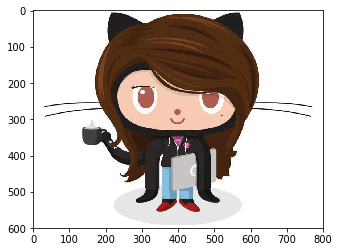

In [4]:
content_image = scipy.misc.imread("images/image.jpg")
imshow(content_image)

In [5]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C, [m, -1, n_C])
    a_G_unrolled = tf.reshape(a_G, [m, -1, n_C])
    
    # compute the cost with tensorflow (≈1 line)
    J_content = 1 / (4 * n_H * n_W * n_C) * tf.reduce_sum(tf.squared_difference(a_C_unrolled, a_G_unrolled))
        
    return J_content

In [6]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.7655926


In [7]:
from PIL import Image

basewidth = 800
img = Image.open('images/style.jpg')
wpercent = (basewidth/float(img.size[0]))
hsize = 600
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
img.save('images/style.jpg') 

/home/preeti/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


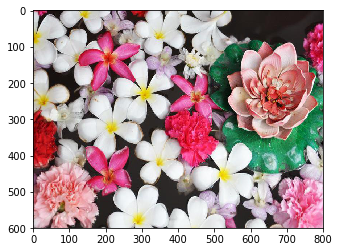

In [8]:
style_image = scipy.misc.imread("images/style.jpg")
imshow(style_image)

In [9]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    GA = tf.matmul(A, tf.transpose(A))
        
    return GA

In [10]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))

GA = [[ 6.422305 -4.429122 -2.096682]
 [-4.429122 19.465837 19.563871]
 [-2.096682 19.563871 20.686462]]


In [11]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.transpose(tf.reshape(a_S, [n_H * n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H * n_W, n_C]))

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = 1 / (4 * n_C**2 * (n_H*n_W)**2) * tf.reduce_sum(tf.squared_difference(GS, GG))
    
        
    return J_style_layer

In [12]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.190278


In [13]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [14]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [15]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    ### START CODE HERE ### (≈1 line)
    J = alpha * J_content + beta * J_style
    ### END CODE HERE ###
    
    return J

In [16]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


In [17]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [18]:
content_image = scipy.misc.imread("images/image.jpg")
content_image = reshape_and_normalize_image(content_image)

/home/preeti/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


In [19]:
style_image = scipy.misc.imread("images/style.jpg")
style_image = reshape_and_normalize_image(style_image)

/home/preeti/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


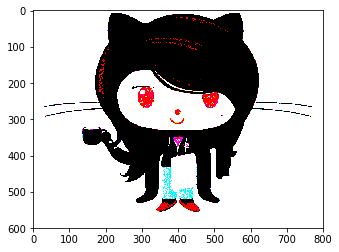

In [20]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [21]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [22]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [23]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [24]:
J = total_cost(J_content, J_style)

In [25]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

In [26]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
        
    # Run the noisy input image (initial generated image) through the model. Use assign().
    sess.run(model['input'].assign(input_image))
        
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
                
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])
        
        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [27]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 15367845000.0
content cost = 12313.28
style cost = 384193060.0
Iteration 20 :
total cost = 2897325300.0
content cost = 27122.236
style cost = 72426350.0
Iteration 40 :
total cost = 1225016600.0
content cost = 28957.24
style cost = 30618176.0
Iteration 60 :
total cost = 732445500.0
content cost = 29706.871
style cost = 18303710.0
Iteration 80 :
total cost = 493932380.0
content cost = 30084.348
style cost = 12340789.0
Iteration 100 :
total cost = 357793100.0
content cost = 30302.861
style cost = 8937251.0
Iteration 120 :
total cost = 272890500.0
content cost = 30451.908
style cost = 6814649.5
Iteration 140 :
total cost = 216725460.0
content cost = 30576.49
style cost = 5410492.5
Iteration 160 :
total cost = 177920900.0
content cost = 30699.75
style cost = 4440347.5
Iteration 180 :
total cost = 150229660.0
content cost = 30818.045
style cost = 3748037.2


array([[[[-43.406906  , -25.18577   ,  23.615965  ],
         [-38.35913   , -47.38094   ,  -7.5609536 ],
         [-25.64077   , -13.008982  ,   5.4766335 ],
         ...,
         [ -1.2491965 ,  -0.47332913, -32.264545  ],
         [ 49.614124  ,  26.016014  ,  -9.556801  ],
         [ 25.536633  ,  51.32097   ,  18.627144  ]],

        [[-22.75209   ,  -6.1035733 ,  53.220272  ],
         [-63.50469   , -29.805964  ,  56.41168   ],
         [-16.738316  , -18.32267   ,  64.896996  ],
         ...,
         [ 21.040817  , -10.746357  , -21.918528  ],
         [ 57.786194  ,  21.461329  ,  38.09774   ],
         [ 79.44943   ,  54.16969   ,  50.021423  ]],

        [[ -4.392864  ,  65.65555   ,  91.56121   ],
         [-22.2204    ,  49.93934   ,  93.11974   ],
         [ -0.5938663 ,   3.5404909 ,  66.59157   ],
         ...,
         [ 70.93257   ,   1.3986756 ,  64.12966   ],
         [ 89.27263   ,  71.73834   ,  94.6353    ],
         [ 91.52519   ,  27.210169  ,  71.10921   ]],